# Librerias

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, recall_score, precision_score
from xgboost import XGBClassifier
seed = 42

# Lectura

In [3]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

# XGBoost

In [4]:
param_grid = {
    "n_estimators": [x for x in range(1,401,50)],
    "alpha": [0.001, 0.01, 0.1,0.5, 1],
    "lambda": [0.001, 0.01, 0.1,0.5, 1],
    "eta": [0.1, 0.05, 0.03, 0.01]
}

kfold = KFold(n_splits=5,shuffle=True,random_state=seed)

grid_search_xgb = GridSearchCV(XGBClassifier(random_state = seed
                                            ,colsample_bytree = 0.3
                                            )
                            ,param_grid=param_grid
                            ,scoring="roc_auc"
                            ,cv=kfold
                            ,n_jobs=-1
                            ,verbose=0
                            ,return_train_score=True)

grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.3,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     inte...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1],
                         'eta': [0.1, 0.05, 0.03, 0.01],
                         'lambda': [0.001, 0.01, 0.1, 0.5, 1],
                         'n_estimators': [1, 51, 101, 151, 201, 251, 301, 351]},
             return_train_score=True, scoring='roc_auc')

In [5]:
print(f'Mejor modelo cuenta con parametros: {grid_search_xgb.best_estimator_}')
print(f'El AUC es de: {round(grid_search_xgb.best_score_,3)}')

Mejor modelo cuenta con parametros: XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0.1,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=351, n_jobs=None, ...)
El AUC es de: 0.902


# Visualizacion de parametros

Train vs Test en validacion cruzada

In [18]:
n_estimators_list = list(grid_search_xgb.cv_results_['param_n_estimators'].data)
eta_list = list(grid_search_xgb.cv_results_['param_eta'].data)
alpha_list = list(grid_search_xgb.cv_results_['param_alpha'].data)
lambda_list = list(grid_search_xgb.cv_results_['param_lambda'].data)

mean_test_score_list = list(grid_search_xgb.cv_results_['mean_test_score'])
mean_train_score_list = list(grid_search_xgb.cv_results_['mean_train_score'])

xgb_df = pd.DataFrame(list(zip(n_estimators_list, eta_list, alpha_list, lambda_list, mean_train_score_list, mean_test_score_list)),
                                columns=['n_estimators','eta','alpha','lambda', 'mean_train_score', 'mean_test_score'])

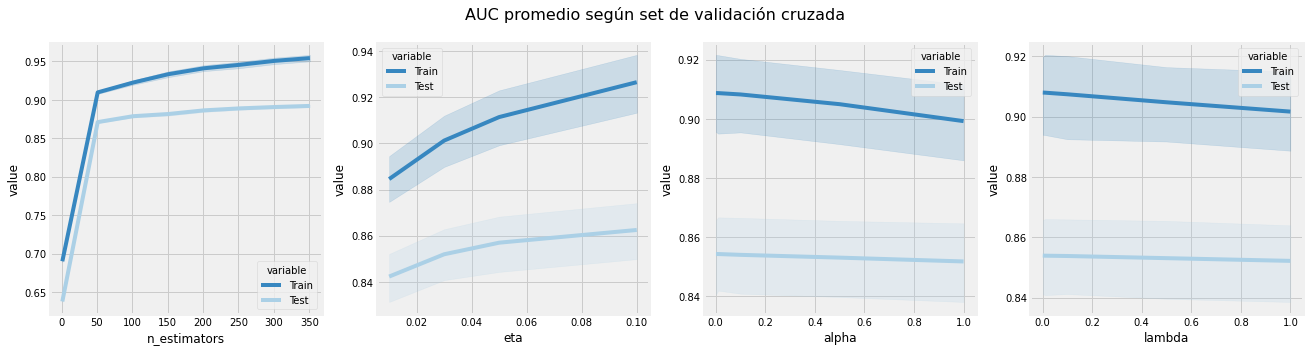

In [31]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
fig.suptitle("AUC promedio según set de validación cruzada", fontsize=16)

for i,param in enumerate(['n_estimators','eta','alpha','lambda']):
    df_melt = xgb_df.melt(id_vars=[param],value_vars= ['mean_train_score','mean_test_score'])
    df_melt.variable.replace({'mean_train_score':'Train',
                    'mean_test_score':'Test'},inplace=True)

    sns.lineplot(data=df_melt, x=param, y="value", hue="variable", ax=axes[i], palette ='Blues_r')

# Importancia de variables

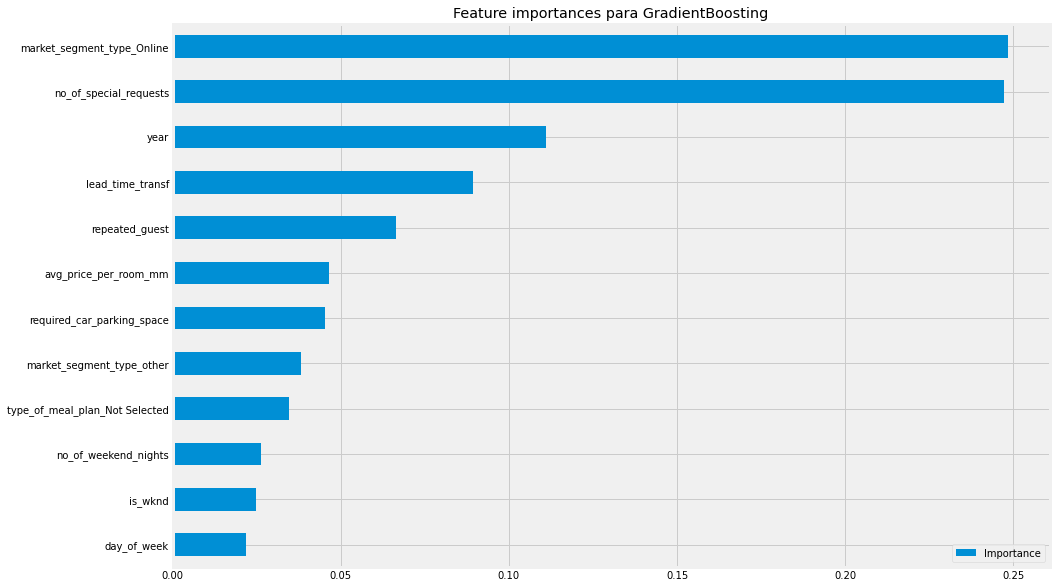

In [20]:
pd.DataFrame(grid_search_xgb.best_estimator_.feature_importances_.tolist(), index=X_train.columns, columns=['Importance']).sort_values('Importance').plot.barh(figsize=(14,10))
plt.title('Feature importances para GradientBoosting')
plt.show()

# Resultados CV test

In [21]:
results = cross_validate(
    grid_search_xgb.best_estimator_,
    X_train,
    y_train,
    cv=kfold,
    scoring=['accuracy', 'precision', 'recall', "f1", "roc_auc"],
    return_train_score=False,
    n_jobs=-1
)

results_xgb = pd.DataFrame(results)

In [22]:
mean_results = pd.DataFrame(results_xgb.mean(axis=0), columns=['test_cv'])
mean_results

,test_cv
fit_time,0.31
score_time,0.02
test_accuracy,0.84
test_precision,0.79
test_recall,0.70
test_f1,0.74
test_roc_auc,0.90


In [23]:
mean_results.to_csv('../data/cv_results/xgb.csv', index=False)

# Resultados test

In [24]:
preds = grid_search_xgb.predict(X_test)
print(classification_report(y_test,preds))
print(roc_auc_score(y_test,preds))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       603
           1       0.77      0.64      0.70       297

    accuracy                           0.82       900
   macro avg       0.80      0.77      0.78       900
weighted avg       0.81      0.82      0.81       900

0.7734559525604302


# Guardamos modelo y resultados

In [25]:
resultados_dict = {
    'AUC': roc_auc_score(y_test,preds),
    'Accuracy': accuracy_score(y_test,preds),
    'Recall': recall_score(y_test,preds),
    'Precision': precision_score(y_test,preds),
    'F1_score': f1_score(y_test,preds)
}

In [26]:
resultados = pd.DataFrame(resultados_dict,index=['Resultados en test']).T

In [27]:
resultados

,Resultados en test
AUC,0.77
Accuracy,0.82
Recall,0.64
Precision,0.77
F1_score,0.70


In [28]:
resultados.to_csv('../data/resultados/xgb.csv',index=False)

In [29]:
import pickle
pickle.dump(grid_search_xgb, open('../data/modelos/xgb.pkl', 'wb'))